In [1]:
# SIMULATED_BNS_SAMPLES.IPYNB -- simulate mock samples for population of GW signals from BNS coalescences

In [2]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# define constants

G = 6.67e-8
c = 2.998e10
Msol = 1.99e33

In [4]:
# user input

SCENARIO = 'O5' # O4, O5, 3G
SCENARIOTAG = 'y2' # can add y2, w1, m1 tags to make O5y2 or 3Gw1, 3Gm1

npop = {'O4': 4, 'O5': 17, 'O5y2': 34, '3Gw1': 112, '3Gm1': 485, '3G': 5823}[SCENARIO+SCENARIOTAG] # number of events in population
nsamps = 1000 # number of samples per event

1.4782338600034926 1.2601197709386187 356.21751413953854


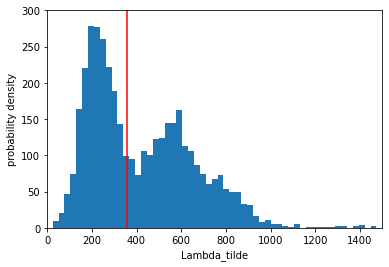

In [5]:
# load GW170817 data

GW170817path = './etc/GW170817_lospin.csv' # public GW170817 posterior samples from https://dcc.ligo.org/LIGO-P1800061/public
GW170817dat = np.genfromtxt(GW170817path,names=True,delimiter=',',dtype=None,encoding=None)
GW170817m1s = GW170817dat['m1_source']
GW170817m2s = GW170817dat['m2_source']
GW170817L1s = GW170817dat['Lambda1']
GW170817L2s = GW170817dat['Lambda2']

GW170817Lts = [16.*((m1+12*m2)*m1**4*L1+(m2+12*m1)*m2**4*L2)/(13.*(m1+m2)**5) for m1,m2,L1,L2 in zip(GW170817m1s,GW170817m2s,GW170817L1s,GW170817L2s)]

GW170817m1 = np.median(GW170817m1s)
GW170817m2 = np.median(GW170817m2s)
GW170817Lt = np.median(GW170817Lts)
print(GW170817m1,GW170817m2,GW170817Lt)

GW170817snr = 33.
GW170817dLt = 700./2
GW170817dmc = 0.005/2
GW170817dq = 0.27/2
GW170817dDLt = 5000./2

plt.hist(GW170817Lts,bins=int(np.sqrt(len(GW170817Lts))))
plt.axvline(GW170817Lt,0.,300.,c='r')
plt.xlim(0.,1500.)
plt.ylim(0.,300.)
plt.xlabel('Lambda_tilde')
plt.ylabel('probability density')
plt.show()

In [6]:
# define transformed observables

def mchirp_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return eta_from_mass1_mass2(mass1, mass2)**(3./5) * (mass1+mass2)

def eta_from_mass1_mass2(mass1, mass2):
    """Returns the symmetric mass ratio from mass1 and mass2."""
    return mass1*mass2 / (mass1+mass2)**2.

def q_from_mass1_mass2(mass1, mass2):
    """Returns the chirp mass from mass1 and mass2."""
    return mass2/mass1

def chi_eff(mass1, mass2, spin1z, spin2z): 
    """Returns the effective spin from mass1, mass2, spin1z, and spin2z."""
    return (spin1z * mass1 + spin2z * mass2) / (mass1 + mass2)

def lambdatilde(lambda1,lambda2,m1,m2): 
    mtotal = m1+m2
    m1fac=m1+12*m2
    m2fac=m2+12*m1
    return 16./13*(m1fac*m1**(4)*lambda1+m2fac*m2**(4)*lambda2)/mtotal**(5)

def mcq_to_m1m2(mc,q):
    
    factor = mc*np.power(1+q, 1./5.)
    m1 = factor*np.power(q, -3./5.)
    m2 = factor*np.power(q, 2./5.)
    
    return m1,m2

def Deltalambdatilde(lambda1,lambda2,q):
    oneplusq6 = np.power(1+q,6)
    m1fac=(1319.-7996.*q-11005.*q*q)/1319./oneplusq6
    m2fac=np.power(q,4)*(1319.*q*q-7996.*q-11005.)/1319./oneplusq6
    return (m1fac*lambda1-m2fac*lambda2)

def Lambda1_of_tilde(LambdaT,DLambdaT,m1,m2):
    mtotal = m1+m2
    q=m2/m1
    FactorLT1=16./13*(m1+12*m2)*m1**(4)/mtotal**(5)
    oneplusq6 = np.power(1+q,6)
    FactorDLT1=(1319.-7996.*q-11005.*q*q)/1319./oneplusq6
    
    FactorLT2=16./13*(m2+12*m1)*m2**(4)/mtotal**(5)
    oneplusq6 = np.power(1+q,6)
    FactorDLT2=np.power(q,4)*(1319.*q*q-7996.*q-11005.)/1319./oneplusq6
    
    return (FactorDLT2*LambdaT+FactorLT2*DLambdaT)/(FactorDLT2*FactorLT1+FactorLT2*FactorDLT1)
    
def Lambda2_of_tilde(LambdaT,DLambdaT,m1,m2):
    mtotal = m1+m2
    q=m2/m1
    FactorLT1=16./13*(m1+12*m2)*m1**(4)/mtotal**(5)
    oneplusq6 = np.power(1+q,6)
    FactorDLT1=(1319.-7996.*q-11005.*q*q)/1319./oneplusq6
    
    FactorLT2=16./13*(m2+12*m1)*m2**(4)/mtotal**(5)
    oneplusq6 = np.power(1+q,6)
    FactorDLT2=np.power(q,4)*(1319.*q*q-7996.*q-11005.)/1319./oneplusq6

    return (FactorDLT1*LambdaT-FactorLT1*DLambdaT)/(FactorDLT1*FactorLT2+FactorLT1*FactorDLT2)

In [7]:
# draw samples from distributions for each binary

POP_PATH = './dat/{0}_unif_BNS_DBHF2010/BNS_MassesSpinsLambdas.csv'.format(SCENARIO)
OUT_PATH = './dat/{0}_unif_BNS_DBHF2010/BNS_MassesSpinsLambdas_detected.csv'.format(SCENARIO+SCENARIOTAG)
outfile = open(OUT_PATH,'w')
outfile.write('m1,m2,chi1,chi2,Lambda1,Lambda2,dl,snr,dec,ra,theta_jn,psi,phase\n')

pop = np.genfromtxt(POP_PATH,names=True,delimiter=',',dtype=None,encoding=None) # load population

snrs = pop['snr']
m1s = pop['m1']
m2s = pop['m2']
L1s = pop['Lambda1']
L2s = pop['Lambda2']
chi1s = pop['chi1']
chi2s = pop['chi2']
dls = pop['dl']
decs = pop['dec']
ras = pop['ra']
thetajns = pop['theta_jn']
psis = pop['psi']
phases = pop['phase']

mcs = mchirp_from_mass1_mass2(m1s,m2s)
qs = q_from_mass1_mass2(m1s,m2s)
Lts = lambdatilde(L1s,L2s,m1s,m2s)
DLts = Deltalambdatilde(L1s,L2s,m2s/m1s)

dmcs = [GW170817dmc*GW170817snr/snr for snr in snrs]
dqs = [GW170817dq*GW170817snr/snr for snr in snrs]
dLts = [GW170817dLt*GW170817snr/snr for snr in snrs]
dDLts = [GW170817dDLt*GW170817snr/snr for snr in snrs]

i = 0
for k,(snr,mc,dmc,q,dq,Lt,dLt,DLt,dDLt) in enumerate(zip(snrs,mcs,dmcs,qs,dqs,Lts,dLts,DLts,dDLts)):
    
    if k > npop: break
    
    if snr <= 12.: continue # impose detection threshold of snr 12
    
    outfile.write('{0:.6f},{1:.6f},{2:.6f},{3:.6f},{4:.6f},{5:.6f},{6:.6f},{7:.6f},{8:.6f},{9:.6f},{10:.6f},{11:.6f},{12:.6f}\n'.format(m1s[k],m2s[k],chi1s[k],chi2s[k],L1s[k],L2s[k],dls[k],snrs[k],decs[k],ras[k],thetajns[k],psis[k],phases[k]))
    
    m1_samps, m2_samps, L1_samps, L2_samps = [], [], [], []
    
    for j in range(nsamps):
    
        m1_samp, m2_samp, mc_samp, q_samp, Lt_samp, L1_samp, L2_samp = [-1.,-1.,-1.,-1.,-1.,-1.,-1.]
        
        while m1_samp < 0. or m2_samp < 0. or mc_samp < 0. or q_samp < 0. or q_samp > 1.:
            mc_samp = np.random.normal(mc+np.random.normal(0.,dmc/1.645),dmc/1.645)
            q_samp = np.random.normal(q+0.3*np.random.normal(0.,dq/1.645),dq/1.645)
            # including white noise with same standard deviation that moves the median, same correction factors as in https://arxiv.org/abs/2003.04880
            m1_samp, m2_samp = mcq_to_m1m2(mc_samp,q_samp)
            
        while (L1_samp < 0.) or (L2_samp < 0.) or (L1_samp > L2_samp) or Lt_samp < 0.:
                
            Lt_samp = np.random.normal(Lt+0.5*np.random.normal(0.,dLt/1.645),dLt/1.645)
            DLt_samp = np.random.normal(DLt+0.*np.random.normal(0.,dDLt/1.645),dDLt/1.645)
            # including white noise with same standard deviation that moves the median, same correction factors as in https://arxiv.org/abs/2003.04880
            L1_samp, L2_samp = Lambda1_of_tilde(Lt_samp,DLt_samp,m1_samp,m2_samp), Lambda2_of_tilde(Lt_samp,DLt_samp,m1_samp,m2_samp)
    
        m1_samps += [m1_samp]
        m2_samps += [m2_samp]
        L1_samps += [L1_samp]
        L2_samps += [L2_samp]
          
    np.savetxt('./dat/{1}_unif_BNS_DBHF2010/BNS_{0}.csv'.format(i,SCENARIO+SCENARIOTAG),np.column_stack([m1_samps,m2_samps,L1_samps,L2_samps]),delimiter=',',comments='',header='m1,m2,Lambda1,Lambda2')

    i += 1
    
outfile.close()

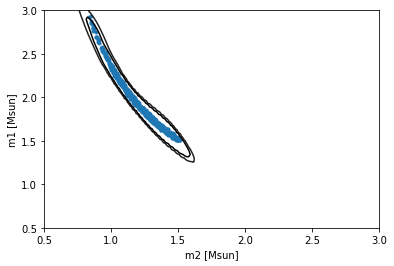

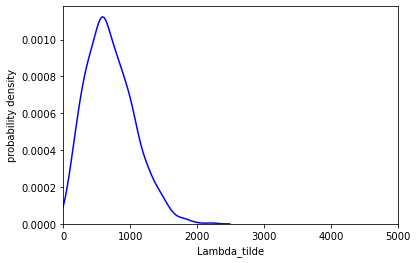

In [8]:
# plot one set of samples to see what they look like

bnsdat = np.genfromtxt('./dat/{0}_unif_BNS_DBHF2010/BNS_0.csv'.format(SCENARIO+SCENARIOTAG),names=True,delimiter=',',dtype=None,encoding=None)

sns.kdeplot(bnsdat['m2'],bnsdat['m1'],levels=[0.1,0.5],color='k')
plt.scatter(bnsdat['m2'],bnsdat['m1'],marker='.')
plt.xlim(0.5,3.)
plt.ylim(0.5,3.)
plt.xlabel('m2 [Msun]')
plt.ylabel('m1 [Msun]')
plt.show()

sns.kdeplot(lambdatilde(bnsdat['Lambda1'],bnsdat['Lambda2'],bnsdat['m1'],bnsdat['m2']),color='b')
plt.xlim(0.,5000.)
plt.xlabel('Lambda_tilde')
plt.ylabel('probability density')
plt.show()